In [1]:
# ================================
# 1. Import necessary libraries
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
from google.colab import files

# Upload the file
uploaded = files.upload()
# Check uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving Weekly Price Latur Soyabean Market.xlsx to Weekly Price Latur Soyabean Market.xlsx
Uploaded file: Weekly Price Latur Soyabean Market.xlsx


In [3]:

# =====================================
# 2. Load and preprocess the data
# =====================================
# Replace this path with the actual path in your Colab session if needed
file_path = '/content/Weekly Price Latur Soyabean Market.xlsx'

# Read Excel, parse dates, rename columns, set Date as index
df = pd.read_excel(file_path, parse_dates=['week_ending_date'])
df = df.rename(columns={'week_ending_date': 'Date', 'Latur_Soya': 'Price'})
df.set_index('Date', inplace=True)

# -------------------------------------
# Quick check: display the first few rows
# -------------------------------------
print("First five rows of the dataset:")
display(df.head())



First five rows of the dataset:


,Price
Date,
2010-01-10,2219.442857
2010-01-17,2178.441429
2010-01-24,2096.861429
2010-01-31,2030.980000
2010-02-07,2122.648571


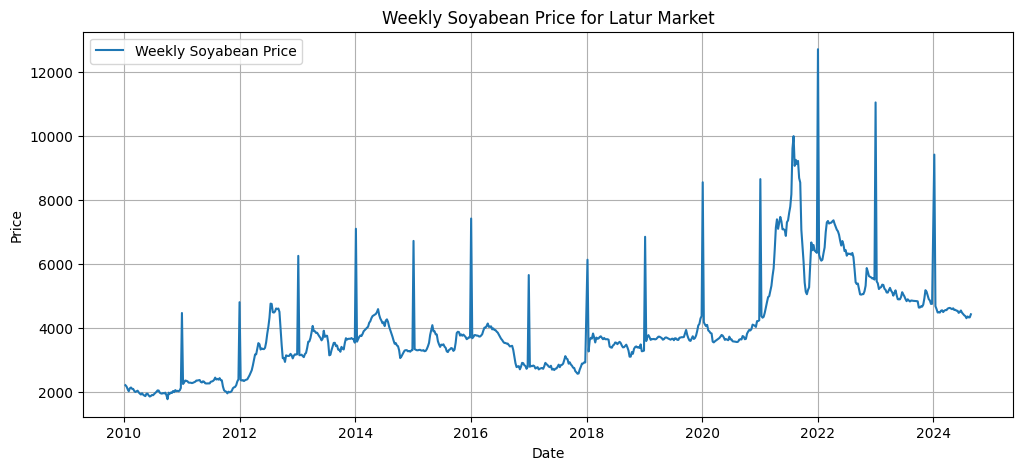

In [4]:

# =====================================
# 3. Plot the original time series
# =====================================
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Price'], label='Weekly Soyabean Price')
plt.title('Weekly Soyabean Price for Latur Market')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [5]:


# ====================================================
# 4. Augmented Dickey–Fuller (ADF) test for stationarity
# ====================================================
adf_result = adfuller(df['Price'])
print(">>> ADF Test on Original Series:")
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")


# If p-value > 0.05, series is non-stationary → we difference once



>>> ADF Test on Original Series:
ADF Statistic: -2.703108
p-value: 0.073502


In [6]:

# ==========================================================
# 5. Differencing once and re-testing stationarity (d = 1)
# ==========================================================
df_diff = df['Price'].diff().dropna()
adf_diff_result = adfuller(df_diff)
print("\n>>> ADF Test on 1st-Differenced Series:")
print(f"ADF Statistic (1st Diff): {adf_diff_result[0]:.6f}")
print(f"p-value (1st Diff): {adf_diff_result[1]:.6f}")

# At this point, if p-value < 0.05, you can set d = 1




>>> ADF Test on 1st-Differenced Series:
ADF Statistic (1st Diff): -10.652773
p-value (1st Diff): 0.000000


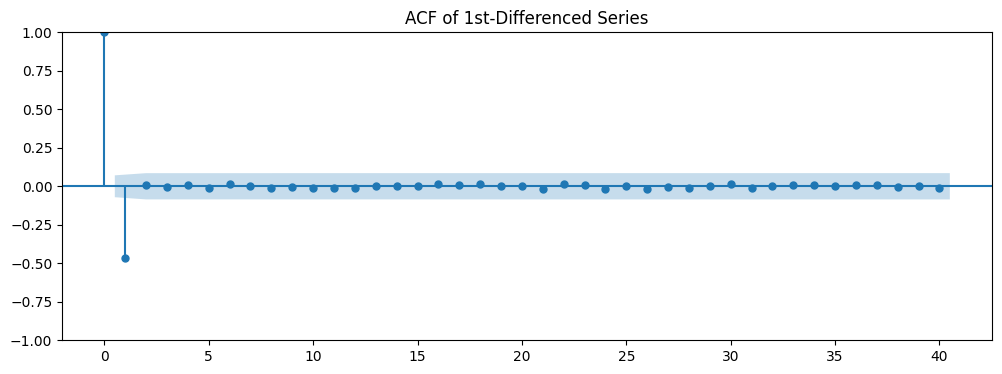

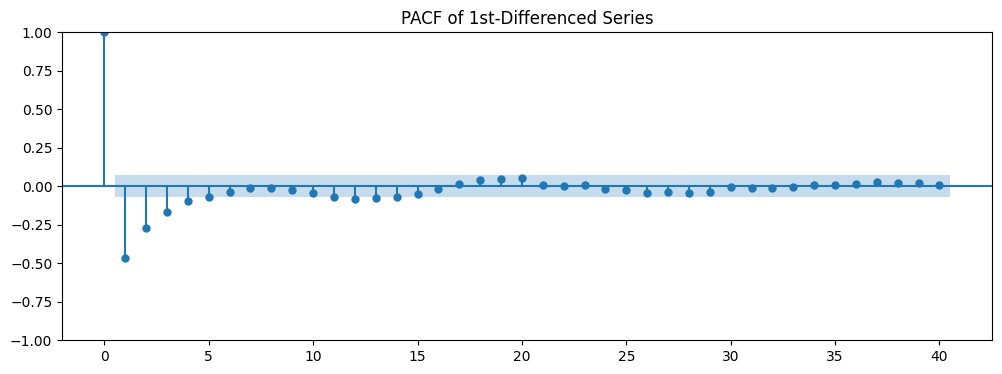

In [8]:

# ==========================================================
# 6. Plot ACF and PACF on the differenced series (d = 1)
# ==========================================================
plt.figure(figsize=(12, 4))
plot_acf(df_diff, ax=plt.gca(), lags=40)
plt.title('ACF of 1st-Differenced Series')
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(df_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF of 1st-Differenced Series')
plt.show()

# From these plots, you’ll eyeball p and q:
#   • p = lag beyond which PACF cuts off
#   • q = lag beyond which ACF cuts off



In [9]:

# ==============================================
# 7. Split data: first 90% → train, last 10% → test
# ==============================================
n = len(df)
train_size = int(n * 0.90)
train = df['Price'][:train_size]
test = df['Price'][train_size:]

print(f"\nTraining samples: {len(train)}  |  Testing samples: {len(test)}")





Training samples: 685  |  Testing samples: 77


In [10]:

# ===============================================
# 8. Build and fit the ARIMA model (p, d, q)
# ===============================================
# For illustration, we’ll pick (p, d, q) = (1, 1, 1).
# In class, show how to decide these from ACF/PACF.
model = ARIMA(train, order=(3, 1, 1))
model_fit = model.fit()
print("\nARIMA Model Summary:")
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  685
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -5395.591
Date:                Tue, 03 Jun 2025   AIC                          10801.182
Time:                        10:29:57   BIC                          10823.821
Sample:                             0   HQIC                         10809.943
                                - 685                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2010      0.045      4.457      0.000       0.113       0.289
ar.L2          0.1518      0.037      4.126      0.000       0.080       0.224
ar.L3          0.0993      0.0

In [11]:

# ======================================================
# 9. In-sample (train) predictions and out-of-sample (test)
# ======================================================
# • In-sample (training) predictions (type='levels')
#   generates fitted values back to original scale.
train_pred = model_fit.predict(start=train.index[0], end=train.index[-1], typ='levels')

# • Out-of-sample (forecast) for the length of test set
test_pred = model_fit.forecast(steps=len(test))



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


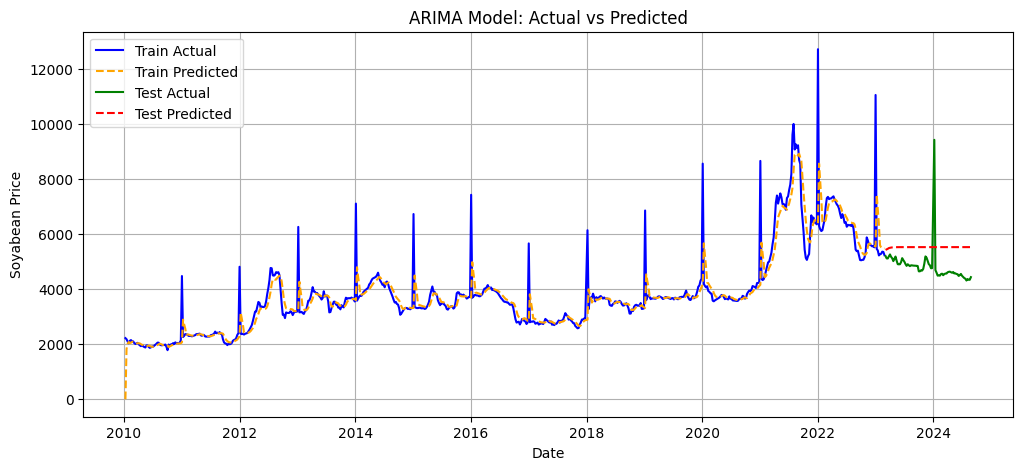

In [12]:

# ======================================================
# 10. Plot actual vs predicted (train + test)
# ======================================================
plt.figure(figsize=(12, 5))
plt.plot(train.index,    train,    label='Train Actual',    color='blue')
plt.plot(train.index,    train_pred, label='Train Predicted', color='orange', linestyle='--')
plt.plot(test.index,     test,     label='Test Actual',     color='green')
plt.plot(test.index,     test_pred, label='Test Predicted',  color='red', linestyle='--')
plt.title('ARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Soyabean Price')
plt.legend()
plt.grid(True)
plt.show()



In [13]:

# ==========================================================
# 11. Compute evaluation metrics: RMSE, MAE, MAPE for both sets
# ==========================================================
def mean_absolute_percentage_error(y_true, y_pred):
    """Compute MAPE, handling zero values gracefully."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Training performance
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
train_mae  = mean_absolute_error(train, train_pred)
train_mape = mean_absolute_percentage_error(train, train_pred)

# Testing performance
test_rmse = np.sqrt(mean_squared_error(test, test_pred))
test_mae  = mean_absolute_error(test, test_pred)
test_mape = mean_absolute_percentage_error(test, test_pred)

print("\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE : {train_mae:.2f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nTesting Metrics:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE : {test_mae:.2f}")
print(f"  MAPE: {test_mape:.2f}%")




Training Metrics:
  RMSE: 649.84
  MAE : 263.31
  MAPE: 5.77%

Testing Metrics:
  RMSE: 914.87
  MAE : 802.32
  MAPE: 16.67%


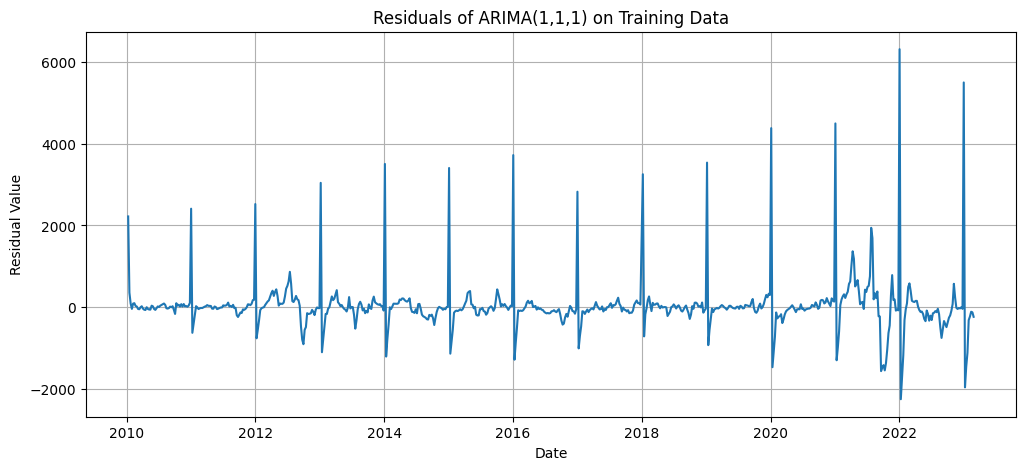

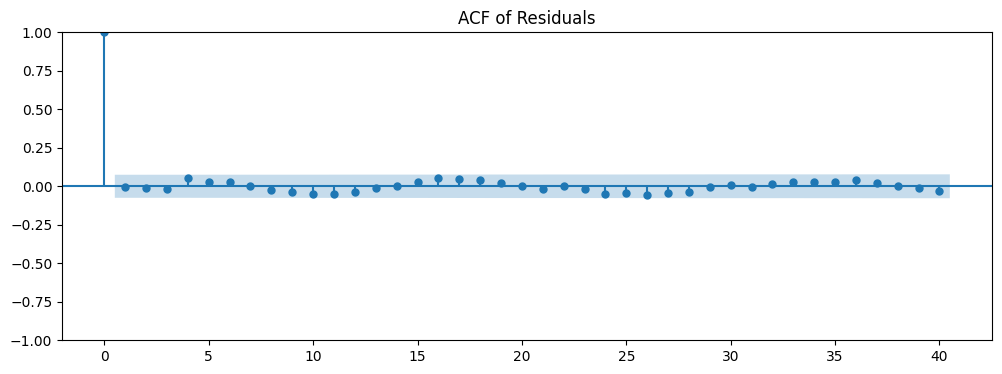


Ljung–Box test (up to lag 10) on Residuals:


,lb_stat,lb_pvalue
10,6.051407,0.810926


In [16]:

# ====================================================
# 12. Check residuals for white noise (autocorrelation)
# ====================================================
residuals = model_fit.resid  # residuals = actual – fitted (in-sample)

plt.figure(figsize=(12, 5))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of ARIMA(1,1,1) on Training Data')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

# ACF of residuals
plt.figure(figsize=(12, 4))
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.title('ACF of Residuals')
plt.show()

# Ljung-Box test (e.g., up to lag 10)
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung–Box test (up to lag 10) on Residuals:")
display(lb_test)
